In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index,approx_brier_score,dist_calibration_score
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

In [2]:
ds2 = pd.read_csv("Datasets/Omar et al/Water_Main_Breaks_-5993635238338754379.csv")
ds1 = pd.read_csv("Datasets/Omar et al/Water_Mains_3460402167144613830.csv")
# ds3 = pd.read_csv("../../Datasets/Omar et al/Roads_4363648288697125466.csv")

### Focus on just ds2

In [3]:
ds2 = ds2[list(ds2.isnull().sum().index[ds2.isnull().sum() < 2000])]

In [4]:
ds2 = ds2.drop(['CW Workorder #','Closest Civic Number','Street','Asset Exists','Current status of the break'
                ,'Status last updated date'], axis = 1)

In [5]:
# We know that there are multiple instances of a pipe breaking more than once, the 'nbr' by the omar et al.so that we don't get
# let's create a column with the no.of breaks of a 'related asset id'.

rel_ass_id = ds2['Related Asset ID'].value_counts()
ds2['Instances'] = ds2['Related Asset ID'].map(rel_ass_id)

### Focus on ds1

In [6]:
ds1 = ds1[list(ds1.isnull().sum().index[ds1.isnull().sum() < 10000])]

In [7]:
ds21 = ds2.merge(ds1,'right',left_on="Related Asset ID",right_on="WATMAINID")

In [8]:
ds21 = ds21.dropna(subset=['INSTALLATION_DATE'])

In [9]:
cols_to_drop = ['Year Asset Installed','OBJECTID_x','OBJECTID_y','Wat Break Incident ID','Road Segment ID','GLOBALID','x','y']
ds21 = ds21.drop(cols_to_drop, axis = 1)

In [10]:
ds21.isnull().sum()

Incident date                  14690
Type of Asset Broken           14690
Nature of Break                14838
Apparent cause of break        14908
Categorization of the Break    14832
Related Asset ID               14690
Asset Size (cm)                14692
Asset Material                 14692
UPDATE_BY                      15011
UPDATE_DATE                    15011
Instances                      14690
WATMAINID                          0
STATUS                             0
PRESSURE_ZONE                      0
ROADSEGMENTID                      0
MAP_LABEL                          0
CATEGORY                           0
PIPE_SIZE                          0
MATERIAL                           0
LINED                              0
LINED_MATERIAL                     0
INSTALLATION_DATE                  0
ACQUISITION                        0
OWNERSHIP                          0
BRIDGE_MAIN                        0
CRITICALITY                        0
REL_CLEANING_AREA                  0
R

In [11]:
# Handling 'Instances' and converting it into the target variable

ds21['Instances'] = ds21['Instances'].fillna(0)
ds21['Instances'] = ds21['Instances'].apply(lambda x: 1 if x != 0.0 else 0)

In [12]:
ds21['Instances'].value_counts()

0    14690
1     2339
Name: Instances, dtype: int64

In [13]:
ds21['Incident date'] = pd.to_datetime(ds21['Incident date'])
ds21['INSTALLATION_DATE'] = pd.to_datetime(ds21['INSTALLATION_DATE'])

In [14]:
ds21['Incident_Month'] = ds21['Incident date'].dt.month
ds21['Incident_Year'] = ds21['Incident date'].dt.year
ds21['Installation_Month'] = ds21['INSTALLATION_DATE'].dt.month
ds21['Installation_Year'] = ds21['INSTALLATION_DATE'].dt.year

ds21 = ds21.drop(['INSTALLATION_DATE','Incident date'], axis = 1)

In [15]:
# final removal of columns that we don't need, or are redundant, like material and pipe size
cols_2_remove = ['Asset Size (cm)','Asset Material','ROADSEGMENTID','Related Asset ID','WATMAINID',
                 'UPDATE_BY','UPDATE_DATE','MAP_LABEL']
ds21 = ds21.drop(cols_2_remove, axis = 1)

In [16]:
ds_breaks = ds21.loc[ds21['Instances'] == 1]

In [17]:
ds_breaks.shape

(2339, 28)

So, we have 2329 breaks (1), and we will have their incident months and years. first let's scale it doewn to the lowest until of time possible in the dataset, that is Months. if we use survival analysis, that tells us the no.of months left until a certain break occurs, then it would be good.

first, we will use the lifelines library. first, use CoxPHM. model linear relationship between the covariates and the population based on time.

for censored data, the 'Year' column will be 'Installation_Year' - 2024. for those pipes that broke, the 'Year' column will be 'Installation_Year' - Incident_Year'. So, basically age of the pipe for censored data, and duration until a break for break data.

In [18]:
def surv_col(x):
    if x['Instances'] == 0:
        return (2024 - x['Installation_Year'])
    else:
        return (x['Incident_Year'] - x['Installation_Year'])
        
surv_breaks = []
for i,row in ds21.iterrows():
    surv_breaks.append(surv_col(row))

In [19]:
ds21['Break_Time'] = surv_breaks

In [20]:
ds21.rename(columns = {'Instances':'Label','Type of Asset Broken':'Broken_asset_type'
                        ,'Nature of Break':'break_nature','Apparent cause of break':'break_cause'
                        ,'Categorization of the Break':'break_category','Condition Score':'Condition_score'
                        ,'Shallow Main':'shallow_main'}, inplace = True)

In [21]:
# also dropping incident dates.

dss = ds21.drop(['STATUS','Broken_asset_type','break_nature','break_cause','break_category','Incident_Month','Incident_Year'], axis = 1)

In [22]:
dss.columns

Index(['Label', 'PRESSURE_ZONE', 'CATEGORY', 'PIPE_SIZE', 'MATERIAL', 'LINED',
       'LINED_MATERIAL', 'ACQUISITION', 'OWNERSHIP', 'BRIDGE_MAIN',
       'CRITICALITY', 'REL_CLEANING_AREA', 'REL_CLEANING_SUBAREA',
       'Undersized', 'shallow_main', 'Condition_score', 'OVERSIZED', 'CLEANED',
       'Shape__Length', 'Installation_Month', 'Installation_Year',
       'Break_Time'],
      dtype='object')

In [23]:
dss = dss.dropna(subset = ['Condition_score'])

In [24]:
nums = random.sample(range(0,16342), 3000)

In [25]:
nums.sort()

In [26]:
dfss = dss.iloc[nums]

In [27]:
dfss.to_csv("more_data_for_surv.csv", index = False)

In [28]:
dfss

,Label,PRESSURE_ZONE,CATEGORY,PIPE_SIZE,MATERIAL,LINED,LINED_MATERIAL,ACQUISITION,OWNERSHIP,BRIDGE_MAIN,...,REL_CLEANING_SUBAREA,Undersized,shallow_main,Condition_score,OVERSIZED,CLEANED,Shape__Length,Installation_Month,Installation_Year,Break_Time
4,0,KIT 6,TREATED,450,DI,NO,NONE,DONATED,DUAL CITY AND REGION,N,...,8,N,N,8.50,N,Y,14.956131,1,1979,45.0
7,0,KIT 6,TREATED,450,DI,NO,NONE,DONATED,DUAL CITY AND REGION,N,...,7,N,N,8.50,N,N,124.970065,1,1979,45.0
14,0,KIT 6,TREATED,200,PVC,NO,NONE,DONATED,KITCHENER,N,...,39,N,N,9.35,N,Y,69.569744,6,2006,18.0
17,0,KIT 5,TREATED,200,PVC,NO,NONE,DONATED,KITCHENER,N,...,24,N,N,9.35,N,Y,8.321570,1,2006,18.0
35,0,KIT 2W,TREATED,150,DI,NO,NONE,DONATED,KITCHENER,N,...,32,N,N,8.50,N,N,0.752107,1,1980,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16868,1,KIT 4,TREATED,150,CI,NO,NONE,DONATED,KITCHENER,N,...,7,N,N,3.95,N,N,2.964207,1,1957,46.0
16926,0,KIT 5,TREATED,300,PVC,NO,NONE,DONATED,KITCHENER,N,...,0,N,N,9.85,N,N,16.757665,1,2019,5.0
16928,0,KIT 4,TREATED,450,CI,NO,NONE,PURCHASED,KITCHENER,N,...,0,N,N,7.75,N,N,15.611054,1,1961,63.0
16930,0,KIT 4,TREATED,300,CI,NO,NONE,PURCHASED,KITCHENER,N,...,29,N,N,7.75,N,N,1.831055,1,1961,63.0


In [29]:
ml_data_cols = ['PRESSURE_ZONE', 'PIPE_SIZE', 'Shape__Length', 'Installation_Year', 'Break_Time',
                'Label', 'Condition_score', 'MATERIAL']
sa_data_cols = ['PRESSURE_ZONE', 'PIPE_SIZE', 'Shape__Length', 'Installation_Year', 'Break_Time',
                'Label', 'Condition_score', 'MATERIAL']
# sa_data_cols = ['PRESSURE_ZONE', 'PIPE_SIZE', 'Shape__Length', 'Break_Time', 'Label', 'MATERIAL']
ml_data = dfss[ml_data_cols]
sa_data = dfss[sa_data_cols]
ml_data = ml_data.reset_index(drop = True)
sa_data = sa_data.reset_index(drop = True)

# Machine Learning

In [30]:
ml_data['Age'] = ml_data['Installation_Year'].apply(lambda x: 2024 - x)
ml_data = ml_data.drop(['Installation_Year'], axis = 1)

In [31]:
ml_data = ml_data.loc[ml_data['Age'] > 0]

In [32]:
ml_data

,PRESSURE_ZONE,PIPE_SIZE,Shape__Length,Break_Time,Label,Condition_score,MATERIAL,Age
0,KIT 6,450,14.956131,45.0,0,8.50,DI,45
1,KIT 6,450,124.970065,45.0,0,8.50,DI,45
2,KIT 6,200,69.569744,18.0,0,9.35,PVC,18
3,KIT 5,200,8.321570,18.0,0,9.35,PVC,18
4,KIT 2W,150,0.752107,44.0,0,8.50,DI,44
...,...,...,...,...,...,...,...,...
2995,KIT 4,150,2.964207,46.0,1,3.95,CI,67
2996,KIT 5,300,16.757665,5.0,0,9.85,PVC,5
2997,KIT 4,450,15.611054,63.0,0,7.75,CI,63
2998,KIT 4,300,1.831055,63.0,0,7.75,CI,63


In [33]:
ml_data.rename(columns = {'PIPE_SIZE':'PIPE_DIAMETER','Shape__Length':'PIPE_LENGTH'}, inplace = True)

One-hot encoding

In [34]:
ml_data = pd.get_dummies(ml_data, columns=['PRESSURE_ZONE','MATERIAL'])

Normalizing

In [35]:
sc = StandardScaler()
sc.fit(ml_data[['PIPE_LENGTH','PIPE_DIAMETER','Age']])
ml_data[['PIPE_LENGTH','PIPE_DIAMETER','Age']] = sc.transform(ml_data[['PIPE_LENGTH','PIPE_DIAMETER','Age']])

Train-test split

In [36]:
test = ml_data.sample(frac = 0.2)
train = ml_data.drop(test.index)

In [37]:
train.shape

(2400, 29)

In [38]:
test.shape

(600, 29)

Cross-validation for model selection

In [39]:
x = train.drop(['Condition_score', 'Label', 'Break_Time'], axis = 1)
y = train['Condition_score']

In [40]:
linreg = LinearRegression()
svrm = LinearSVR()
lass = Lasso()
rid = Ridge()
sgd = SGDRegressor()
rf = RandomForestRegressor()
knns = KNeighborsRegressor()
xgbs = xgb.XGBRegressor()
lgbs = lgb.LGBMRegressor()
lin_scores = cross_val_score(linreg, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
svr_scores = cross_val_score(svrm, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
lasso_scores = cross_val_score(lass, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
ridge_scores = cross_val_score(rid, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
sgd_scores = cross_val_score(sgd, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
rf_scores = cross_val_score(rf, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
knn_scores = cross_val_score(knns, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
xgb_scores = cross_val_score(xgbs, x, y, scoring = 'neg_mean_absolute_error', cv = 10)
lgb_scores = cross_val_score(lgbs, x, y, scoring = 'neg_mean_absolute_error', cv = 10)


scores = [lin_scores,
svr_scores,
lasso_scores,
ridge_scores,
sgd_scores,
rf_scores,
knn_scores,
xgb_scores,
lgb_scores
]


def print_variable(variable):
    variable_name = [name for name, value in locals().items() if value is variable][0]
    print(f"Variable name using locals(): {variable_name}")

for sc in scores:
    print(f"{print_variable(sc)} = {sc.mean()*(-1)}")

C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

Variable name using locals(): variable
None = 0.5941642610058868
Variable name using locals(): variable
None = 0.5134018243614342
Variable name using locals(): variable
None = 1.0087562770061727
Variable name using locals(): variable
None = 0.5948608949041422
Variable name using locals(): variable
None = 0.6284274904588039
Variable name using locals(): variable
None = 0.4237870000000015
Variable name using locals(): variable
None = 0.42254249999999993
Variable name using locals(): variable
None = 0.4610694886684418
Variable name using locals(): variable
None = 0.4418006631758959


Prediction

In [41]:
# Best performing models

rf = RandomForestRegressor
knns = KNeighborsRegressor
xgbs = xgb.XGBRegressor
lgbs = lgb.LGBMRegressor

xtest = test.drop(['Condition_score', 'Label', 'Break_Time'], axis = 1)
ytest = test['Condition_score']

models = [rf,knns,xgbs,lgbs]
evals = {}
for model in models:
    m = model()
    m.fit(x,y)
    preds = m.predict(xtest)
    evals[model.__name__] = [mean_absolute_error(ytest,preds),mean_squared_error(ytest,preds), r2_score(ytest,preds)]

In [42]:
evals

{'RandomForestRegressor': [0.3274531666666676,
  0.5652202756166664,
  0.703720607115417],
 'KNeighborsRegressor': [0.34328, 0.5972426266666666, 0.6869350048694962],
 'XGBRegressor': [0.37995619029998773, 0.6758351748570888, 0.6457380530480037],
 'LGBMRegressor': [0.3762753721516402, 0.5634174885346179, 0.7046655991569477]}

Plotting

In [43]:
models = list(evals.keys())
mae_scores = [evals[model][0] for model in models]
mse_scores = [evals[model][1] for model in models]
r2_scores = [evals[model][2] for model in models]

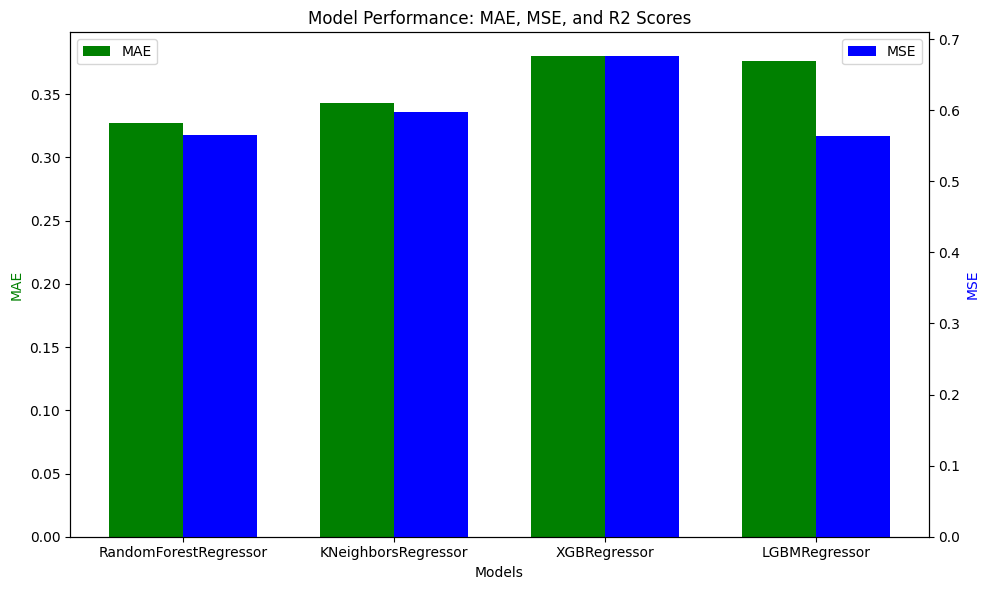

In [44]:
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MAE scores
bar1 = ax1.bar(x - width/2, mae_scores, width, label='MAE', color='green')

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Plotting MSE scores
bar2 = ax2.bar(x + width/2, mse_scores, width, label='MSE', color='blue')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE', color='green')
ax2.set_ylabel('MSE', color='blue')
ax1.set_title('Model Performance: MAE, MSE, and R2 Scores')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# # Annotating R2 scores
# for i in range(len(models)):
#     ax1.annotate(f'R2: {r2_scores[i]:.2f}', 
#                  xy=(x[i], max(mae_scores[i], mse_scores[i]) + 0.02), 
#                  ha='center', fontsize=50, fontweight='bold', color='black')

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.savefig("model_graphs.png")
plt.show()


Feature importance

<AxesSubplot: >

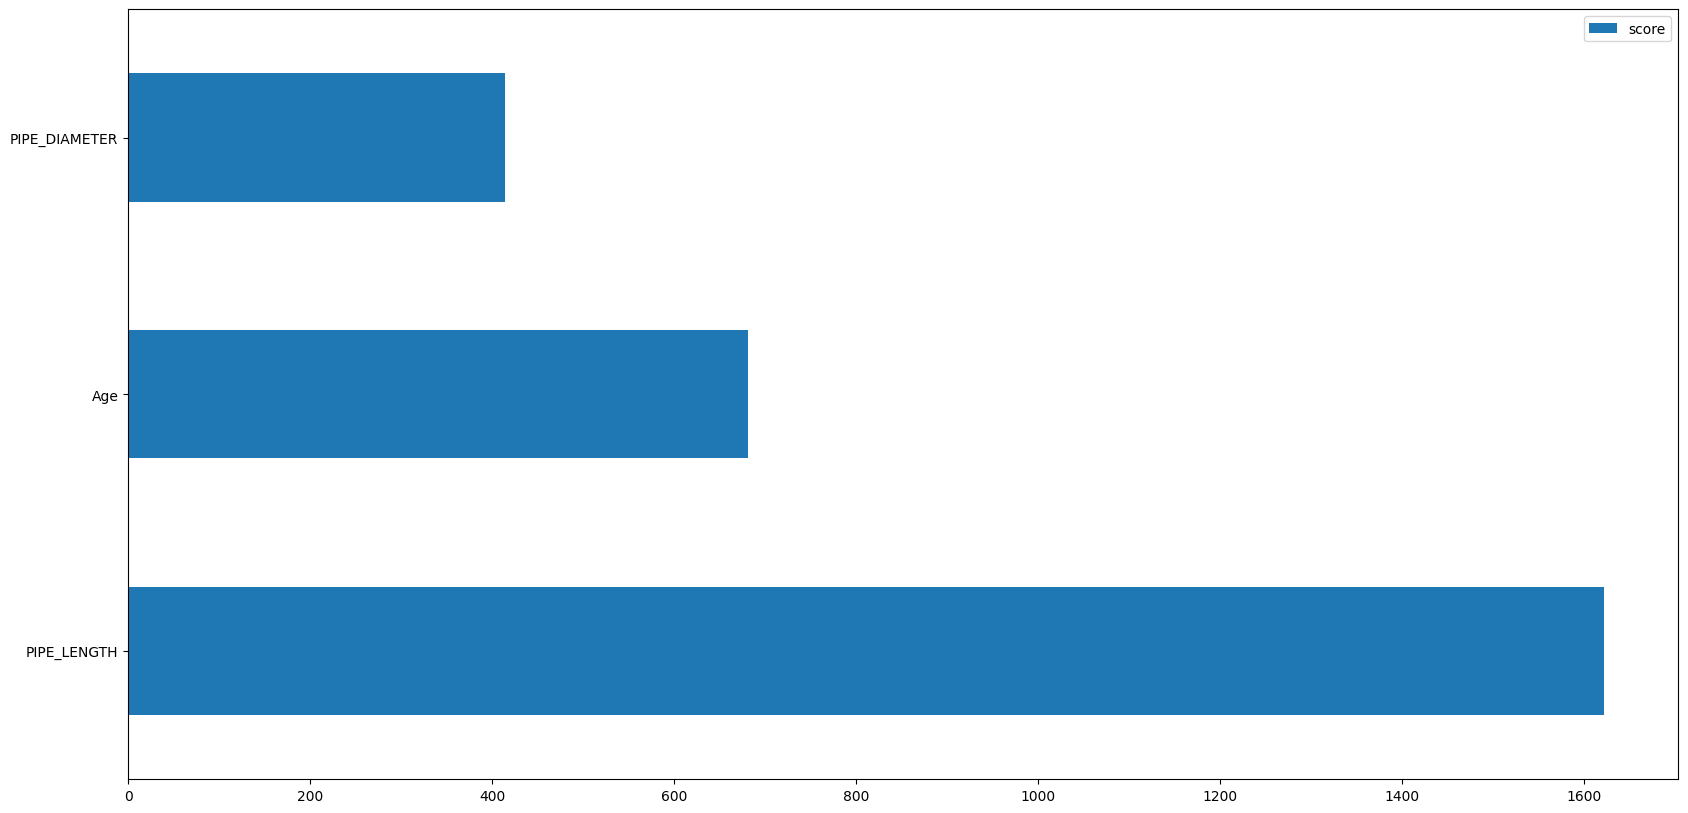

In [45]:

# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot
x = ml_data.drop(['Condition_score', 'Label', 'Break_Time'], axis = 1)
y = ml_data['Condition_score']
fea_model = XGBRegressor()
fea_model.fit(x, y)

feature_important = fea_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(3, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

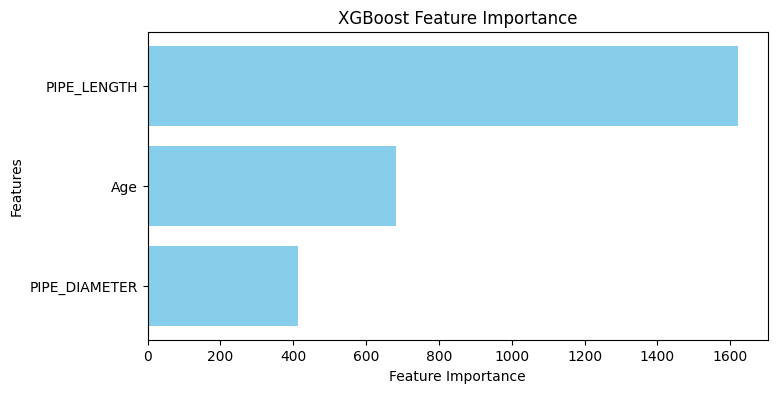

In [46]:
# Get feature importance scores and feature names
feature_importance = fea_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

# Create a DataFrame for better visualization
importance_df = pd.DataFrame(data={'Feature': keys, 'Importance': values})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(3)

# Plot
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.savefig("feat_imp.png")
plt.show()

### Filtering of pipes

In [47]:
import joblib
# The best performing model was Random Forest. So, will use that to predict the condition

rfmodel = RandomForestRegressor()

xtest = test.drop(['Condition_score', 'Label', 'Break_Time'], axis = 1)
ytest = test['Condition_score']

rfmodel.fit(x,y)
preds = rfmodel.predict(xtest)
joblib.dump(rfmodel,"ML_Model.pkl")

['ML_Model.pkl']

In [48]:
predlist = list(preds)

In [49]:
# Combine predictions with the 'Break' column from the test set
result_df = xtest.copy()
result_df['Predicted condition'] = predlist
result_df['Label'] = test.loc[xtest.index, 'Label']

In [50]:
ml_data['Condition_score'].mean()

8.549589999999998

In [51]:
# According to our dataset, the mean of of the condition score column is 8.5. Hence, we will filter out those pipes that are prone.

risk_pipes = result_df.loc[result_df['Predicted condition'] < 8.5]

In [52]:
risk_pipes['Label'].value_counts()

0    103
1     80
Name: Label, dtype: int64

# Survival Analysis

In [53]:
sa_data

,PRESSURE_ZONE,PIPE_SIZE,Shape__Length,Installation_Year,Break_Time,Label,Condition_score,MATERIAL
0,KIT 6,450,14.956131,1979,45.0,0,8.50,DI
1,KIT 6,450,124.970065,1979,45.0,0,8.50,DI
2,KIT 6,200,69.569744,2006,18.0,0,9.35,PVC
3,KIT 5,200,8.321570,2006,18.0,0,9.35,PVC
4,KIT 2W,150,0.752107,1980,44.0,0,8.50,DI
...,...,...,...,...,...,...,...,...
2995,KIT 4,150,2.964207,1957,46.0,1,3.95,CI
2996,KIT 5,300,16.757665,2019,5.0,0,9.85,PVC
2997,KIT 4,450,15.611054,1961,63.0,0,7.75,CI
2998,KIT 4,300,1.831055,1961,63.0,0,7.75,CI


In [54]:
sa_data.rename(columns = {'PIPE_SIZE':'PIPE_DIAMETER','Shape__Length':'PIPE_LENGTH'}, inplace = True)

In [55]:
sa_data['Label'].value_counts()

0    2568
1     432
Name: Label, dtype: int64

In [56]:
sa_data = pd.get_dummies(sa_data, columns = ['MATERIAL','PRESSURE_ZONE'])

In [57]:
sc = StandardScaler()
sc.fit(sa_data[['PIPE_LENGTH','PIPE_DIAMETER']])
sa_data[['PIPE_LENGTH','PIPE_DIAMETER']] = sc.transform(ml_data[['PIPE_LENGTH','PIPE_DIAMETER']])

In [58]:
from lifelines import CoxPHFitter

surv_ress = []
cscores = []
penalizers = [0.0001,0.001,0.01,0.1,1,10]

only_for_cox_data = sa_data.drop(['Installation_Year', 'Condition_score'], axis = 1)
for pen in penalizers:
    wf = CoxPHFitter(penalizer=pen).fit(only_for_cox_data, "Break_Time", "Label")
    censored_subjects = only_for_cox_data.loc[~only_for_cox_data['Label'].astype(bool)]
    censored_subjects_last_obs = censored_subjects['Break_Time']

    # predict new survival function
    surv_ress.append(wf.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs))
    cscores.append(wf.concordance_index_)

# # predict median remaining life
# wf.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)

C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['PIPE_DIAMETER', 'PIPE_LENGTH'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column MATERIAL_COP have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Label'].astype(bool)
>>> print(df.loc[events, 'MATERIAL_COP'].var())
>>> print(df.loc[~events, 'MATERIAL_COP'].var())

A very low variance means that the column MATERIAL_COP completely determines whether a subject dies or not. See ht

In [59]:
cscores

[0.5917356996684628,
 0.593964415609948,
 0.6094287016433876,
 0.779552827001957,
 0.7791417566999991,
 0.7727630179709213]

In [64]:
only_for_cox_test = only_for_cox_data.sample(frac = 0.2)
only_for_cox_train = only_for_cox_data.drop(only_for_cox_test.index)

cph_best = CoxPHFitter(penalizer = 10.0)
cph_best.fit(only_for_cox_train, duration_col='Break_Time', event_col='Label')
censored_subjects = only_for_cox_test.loc[~only_for_cox_test['Label'].astype(bool)]
censored_subjects_last_obs = censored_subjects['Break_Time']

# predict new survival function
cph_best.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs)
joblib.dump(cph_best, "Cox_SA_model.pkl")

C:\Users\asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['PIPE_DIAMETER', 'PIPE_LENGTH'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


['Cox_SA_model.pkl']

In [65]:
print(cph_best.concordance_index_)

0.7537311525320716


With XGBSE

In [66]:
# splitting to X, T, E format
X = sa_data.drop(['Break_Time', 'Label', 'Installation_Year', 'Condition_score'], axis=1)
y = convert_to_structured(sa_data['Break_Time'], sa_data['Label'])

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)

In [68]:
## pre selected params for models ##

PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50, 
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

In [69]:
# Fit XGBoost model to predict a value that is interpreted as a risk metric. Fit Weibull Regression model using risk metric as only independent variable.
# Predicts survival probabilities using the XGBoost + Weibull AFT stacking pipeline.

# converting to xgboost format
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    # num_boost_round=1000,
    # early_stopping_rounds=10,
    # evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} years")
joblib.dump(bst, "XGB_AFT_model.pkl")

C-index: 0.756
Average survival time: 3 years


['XGB_AFT_model.pkl']

In [70]:
# Transform feature space by fitting a XGBoost model and outputting its leaf indices. Build search index in the new space to allow nearest neighbor queries at scoring time.
# Make queries to nearest neighbor search index build on the transformed XGBoost space. Compute a Kaplan-Meier estimator for each neighbor-set. Predict the KM estimators

# training model
xgbse_kaplan = XGBSEKaplanNeighbors(PARAMS_XGB_AFT, n_neighbors=30)

xgbse_kaplan.fit(
    X_train, y_train
    # validation_data = (X_valid, y_valid)
    # early_stopping_rounds=10,
    # time_bins=TIME_BINS
)

# predicting
preds = xgbse_kaplan.predict(X_valid)

# running metrics
print(f'C-index: {concordance_index(y_valid, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_valid, preds)}')
print(f"""D-Calibration: {dist_calibration_score(y_valid, preds) > 0.05}""")
joblib.dump(xgbse_kaplan, "XGB_KM_N_model.pkl")

C-index: 0.7955845192179811
Avg. Brier Score: 0.12022757719014798
D-Calibration: True


['XGB_KM_N_model.pkl']

In [71]:
# Fit a single decision tree using xgboost. For each leaf in the tree, build a Kaplan-Meier estimator.
# Run samples through tree until terminal nodes. Predict the Kaplan-Meier estimator associated to the leaf node each sample ended into.

xgbse_km_tree = XGBSEKaplanTree(PARAMS_TREE)
xgbse_km_tree.fit(
    X_train, y_train
)

# predicting
preds = xgbse_km_tree.predict(X_valid)

print(f'C-index: {concordance_index(y_valid, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_valid, preds)}')
print(f"""D-Calibration: {dist_calibration_score(y_valid, preds) > 0.05}""")
joblib.dump(xgbse_km_tree, "XGB_KM_TREE_model.pkl")

C-index: 0.771046681739593
Avg. Brier Score: 0.1127032896148968
D-Calibration: True


['XGB_KM_TREE_model.pkl']

In [72]:
# Predicts survival probabilities using the XGBoost + Logistic Regression pipeline.
# Train a set of logistic regressions on top of the leaf embedding produced by XGBoost, each predicting survival at different user-defined discrete time windows. 
# The classifiers remove individuals as they are censored, with targets that are indicators of surviving at each window.

# base model
base_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)

# # bootstrap meta estimator
# bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=5)

# fitting the meta estimator
base_model.fit(
    X_train,
    y_train
)

# predicting
preds = base_model.predict(X_valid)

# running metrics
print(f'C-index: {concordance_index(y_valid, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_valid, preds)}')
print(f"""D-Calibration: {dist_calibration_score(y_valid, preds) > 0.05}""")
joblib.dump(base_model, "XGB_LOR_model.pkl")

C-index: 0.8172629339007846
Avg. Brier Score: 0.10764315439921397
D-Calibration: True


['XGB_LOR_model.pkl']

In [82]:
# After the above step, decide the best performing model. the next step is to decide 5 pipes that will go.
# The best model will predict the 'Break_Time' for the 'risk_pipes' dataset
# Remove columns if necessary

# So, cox model does perform well, however often we are faced with convergence error. Yet, this time the best model isit is the best.

# Compare the columns of X_valid and risk_pipes

surv_cols = list(X_valid.columns)
# sorted(surv_cols)

In [83]:
ml_cols = list(risk_pipes.columns)
# sorted(ml_cols)

#### Only if the best model is Cox

In [90]:
# So the columns are matching. Now, we need to remove 'Predicted condition' and 'Label' from 'risk_pipes', because we want to predict.
# Just for this. And only for those pipes that are labelled '0'.
for_surv_pred_risk_pipes = risk_pipes.loc[risk_pipes['Label'] == 0]
for_surv_pred_risk_pipes = for_surv_pred_risk_pipes.drop(['Predicted condition', 'Label'], axis = 1)

In [95]:
# Load the model and predict the survival function

pred_model = joblib.load("Cox_SA_model.pkl")

In [96]:
censored_subjects_last_obs = for_surv_pred_risk_pipes['Age']
preds = pred_model.predict_survival_function(for_surv_pred_risk_pipes, conditional_after = censored_subjects_last_obs)

#### Best model other than Cox

In [181]:
risk_pipes.to_csv("risk_prone_pipes.csv", index = True)

In [75]:
for_surv_pred_risk_pipes = risk_pipes.drop(['Age', 'Predicted condition', 'Label'], axis = 1)

In [76]:
pred_model = joblib.load("XGB_LOR_model.pkl")

In [78]:
for_surv_pred_risk_pipes.shape

(183, 25)

In [84]:
surv_cols

['PIPE_DIAMETER',
 'PIPE_LENGTH',
 'MATERIAL_AC',
 'MATERIAL_CI',
 'MATERIAL_COP',
 'MATERIAL_CPP',
 'MATERIAL_DI',
 'MATERIAL_HDPE',
 'MATERIAL_PVC',
 'MATERIAL_PVCB',
 'MATERIAL_PVCF',
 'MATERIAL_PVCO',
 'MATERIAL_ST',
 'PRESSURE_ZONE_BRESLAU',
 'PRESSURE_ZONE_BRIDGEPORT',
 'PRESSURE_ZONE_KIT 2E',
 'PRESSURE_ZONE_KIT 2EA',
 'PRESSURE_ZONE_KIT 2W',
 'PRESSURE_ZONE_KIT 4',
 'PRESSURE_ZONE_KIT 4A',
 'PRESSURE_ZONE_KIT 5',
 'PRESSURE_ZONE_KIT 6',
 'PRESSURE_ZONE_MANNHEIM',
 'PRESSURE_ZONE_RAW NO ZONE',
 'PRESSURE_ZONE_WAT 4']

In [86]:
list(for_surv_pred_risk_pipes.columns)

['PIPE_DIAMETER',
 'PIPE_LENGTH',
 'PRESSURE_ZONE_BRESLAU',
 'PRESSURE_ZONE_BRIDGEPORT',
 'PRESSURE_ZONE_KIT 2E',
 'PRESSURE_ZONE_KIT 2EA',
 'PRESSURE_ZONE_KIT 2W',
 'PRESSURE_ZONE_KIT 4',
 'PRESSURE_ZONE_KIT 4A',
 'PRESSURE_ZONE_KIT 5',
 'PRESSURE_ZONE_KIT 6',
 'PRESSURE_ZONE_MANNHEIM',
 'PRESSURE_ZONE_RAW NO ZONE',
 'PRESSURE_ZONE_WAT 4',
 'MATERIAL_AC',
 'MATERIAL_CI',
 'MATERIAL_COP',
 'MATERIAL_CPP',
 'MATERIAL_DI',
 'MATERIAL_HDPE',
 'MATERIAL_PVC',
 'MATERIAL_PVCB',
 'MATERIAL_PVCF',
 'MATERIAL_PVCO',
 'MATERIAL_ST']

In [87]:
for_surv_pred_risk_pipes = for_surv_pred_risk_pipes[surv_cols]

In [89]:
preds = pred_model.predict(for_surv_pred_risk_pipes)

In [90]:
preds

,3,10,17,25,32,40,47,55,62,70,77,85
0,0.987604,0.983895,0.981893,0.975344,0.953802,0.870412,0.774642,0.655742,0.425755,0.294226,0.221310,0.199276
1,0.987604,0.983895,0.981893,0.975344,0.953802,0.870412,0.774642,0.655742,0.425755,0.294226,0.221310,0.199276
2,0.995405,0.991351,0.989090,0.976330,0.913961,0.877609,0.793780,0.680567,0.351625,0.249233,0.204682,0.185433
3,0.994737,0.991058,0.988953,0.982534,0.952134,0.872444,0.781637,0.650523,0.426358,0.281225,0.216749,0.195540
4,0.896379,0.891812,0.888416,0.871304,0.840749,0.794817,0.744034,0.670769,0.428510,0.309779,0.249968,0.226113
...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.995405,0.991351,0.989090,0.976330,0.913961,0.877609,0.793780,0.680567,0.351625,0.249233,0.204682,0.185433
179,0.896379,0.891812,0.888416,0.871304,0.840749,0.794817,0.744034,0.670769,0.428510,0.309779,0.249968,0.226113
180,0.987604,0.983895,0.981893,0.975344,0.953802,0.870412,0.774642,0.655742,0.425755,0.294226,0.221310,0.199276
181,0.984777,0.980393,0.978243,0.963289,0.915999,0.877352,0.789716,0.705935,0.331817,0.245805,0.199774,0.180788


In [91]:
preds.to_csv("May18_preds_xgb_lor.csv", index = True)

In [167]:
# Now, pick any 4 pipes with proper indexing.

# Storing indices first
inds_for_surv_pred_risk_pipes = list(for_surv_pred_risk_pipes.index)

# Randomly picking any 4 numbers from the range of 0 to len(for_surv_pred_risk_pipes)

# NOTE:- Randomly picking 4 numbers gives the same trajectory for at least 2 pipes, tried multiple times. Hence, picking manually.
rand_nums_inds = random.sample(range(0,len(for_surv_pred_risk_pipes)), 4)

In [168]:
nums_inds = [181,179,3,1]

In [169]:
final_df = risk_pipes.iloc[nums_inds]

In [170]:
final_df

,PIPE_DIAMETER,PIPE_LENGTH,Age,PRESSURE_ZONE_BRESLAU,PRESSURE_ZONE_BRIDGEPORT,PRESSURE_ZONE_KIT 2E,PRESSURE_ZONE_KIT 2EA,PRESSURE_ZONE_KIT 2W,PRESSURE_ZONE_KIT 4,PRESSURE_ZONE_KIT 4A,...,MATERIAL_CPP,MATERIAL_DI,MATERIAL_HDPE,MATERIAL_PVC,MATERIAL_PVCB,MATERIAL_PVCF,MATERIAL_PVCO,MATERIAL_ST,Predicted condition,Label
2048,0.652872,1.080459,1.111221,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,8.2825,0
2920,-1.830961,-0.444784,-0.939395,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,7.5020,0
163,1.556083,-0.454258,1.202359,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7.8500,0
1353,2.007689,-0.453072,1.156790,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,7.8500,0


In [171]:
final_df_surv = preds.iloc[nums_inds]

In [172]:
final_df_surv

,3,10,17,25,32,40,47,55,62,70,77,85
181,0.984777,0.980393,0.978243,0.963289,0.915999,0.877352,0.789716,0.705935,0.331817,0.245805,0.199774,0.180788
179,0.896379,0.891812,0.888416,0.871304,0.840749,0.794817,0.744034,0.670769,0.428510,0.309779,0.249968,0.226113
3,0.994737,0.991058,0.988953,0.982534,0.952134,0.872444,0.781637,0.650523,0.426358,0.281225,0.216749,0.195540
1,0.987604,0.983895,0.981893,0.975344,0.953802,0.870412,0.774642,0.655742,0.425755,0.294226,0.221310,0.199276


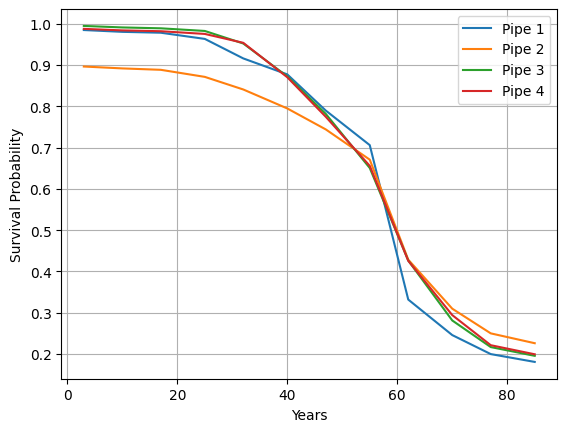

In [176]:
for i in range(len(final_df_surv)):
    plt.plot(final_df_surv.columns, final_df_surv.iloc[i], label=f'Pipe {i+1}')
# Set labels and title
plt.xlabel('Years')
plt.ylabel('Survival Probability')
# plt.title('Probability Values for Each Row')
plt.grid(True)
plt.legend()
plt.savefig("surv_prob_4_pipes.png")
# Show plot
plt.show()

In [178]:
# Based on final_df_surv, let's look at 55 year mark. blue decreses sharply, and hence the order should be 1,3,4,2.
# so even if the 2nd pipe starts with low chance of survial, it is estimate to last longer than the other 3.
order_of_repair = [1,4,2,3]
final_df['Priority'] = order_of_repair

C:\Users\asus_\AppData\Local\Temp\ipykernel_24136\2857652928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Priority'] = order_of_repair


In [179]:
final_df

,PIPE_DIAMETER,PIPE_LENGTH,Age,PRESSURE_ZONE_BRESLAU,PRESSURE_ZONE_BRIDGEPORT,PRESSURE_ZONE_KIT 2E,PRESSURE_ZONE_KIT 2EA,PRESSURE_ZONE_KIT 2W,PRESSURE_ZONE_KIT 4,PRESSURE_ZONE_KIT 4A,...,MATERIAL_DI,MATERIAL_HDPE,MATERIAL_PVC,MATERIAL_PVCB,MATERIAL_PVCF,MATERIAL_PVCO,MATERIAL_ST,Predicted condition,Label,Priority
2048,0.652872,1.080459,1.111221,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,8.2825,0,1
2920,-1.830961,-0.444784,-0.939395,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,7.5020,0,4
163,1.556083,-0.454258,1.202359,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.8500,0,2
1353,2.007689,-0.453072,1.156790,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,7.8500,0,3


In [180]:
data_to_send = final_df[['Predicted condition','Priority']]
data_to_send.to_csv("DATA_FOR_CSP.csv", index = False)

In [183]:
ret = [24,12,56,2]
ret.index(max(ret))

2